### Importing Libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf
import datetime

### Fetching Data

In [2]:
start_date = datetime.datetime(2013,1,1)
end_date   = datetime.datetime(2023,11,1)
stock_symbol = 'WIPRO.NS'
data = yf.download(stock_symbol,start = start_date,end=end_date)
# Create a DataFrame 
df = pd.DataFrame(data)
df.to_csv("df")
df = pd.read_csv("df",parse_dates= True,index_col = "Date")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-01,148.518784,149.625031,146.681290,148.837540,135.361969,2123743
2013-01-02,149.362534,149.718781,146.887543,147.656281,134.287659,2283188
2013-01-03,148.312531,149.625031,147.693787,149.175034,135.668915,4646500
2013-01-04,149.587540,151.837540,149.118790,151.368790,137.664017,4531406
2013-01-07,151.406281,153.187531,151.143784,151.856293,138.107391,3332353
...,...,...,...,...,...,...
2023-10-25,384.399994,387.700012,381.100006,381.850006,381.850006,3339147
2023-10-26,378.799988,380.549988,375.049988,378.250000,378.250000,5497791
2023-10-27,379.049988,384.350006,379.049988,382.350006,382.350006,3101406


### Visualize the stock’s daily closing price

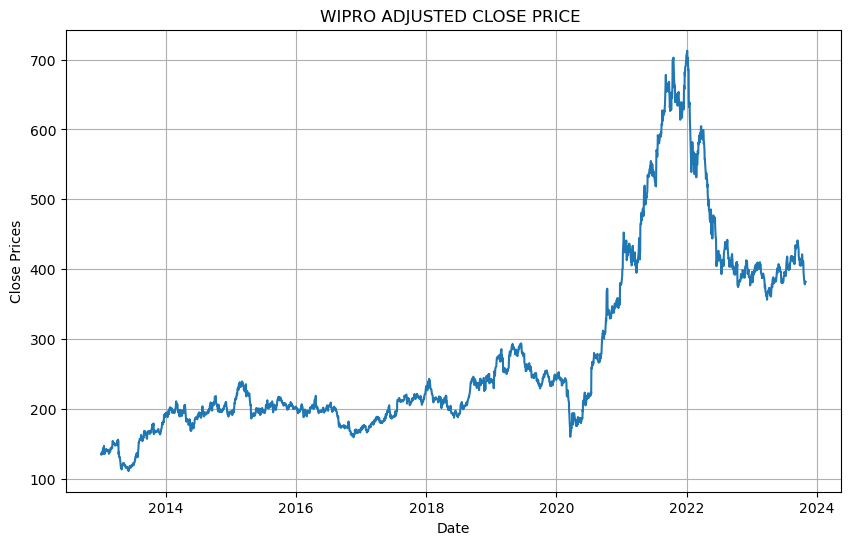

In [3]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Adj Close'])
plt.title('WIPRO ADJUSTED CLOSE PRICE ')
plt.show()

### Distribution of the dataset

<Axes: ylabel='Density'>

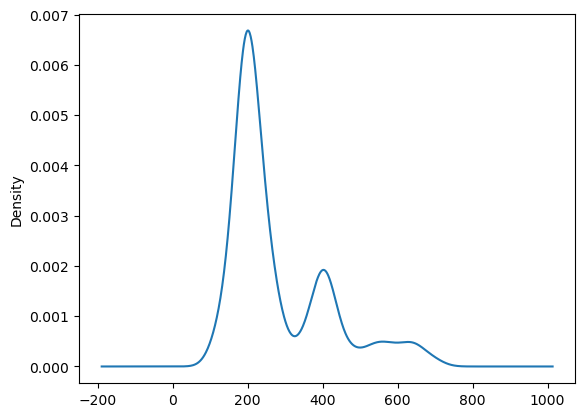

In [4]:
#Distribution of the dataset
df_close = df['Adj Close']
df_close.plot(kind='kde')

## Checking for stationarity

In [5]:
# Checking for stationarity

df_close = df['Adj Close']
result = adfuller(df_close)

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis; the data is stationary.")
else:
    print("Fail to reject the null hypothesis; the data is non-stationary.")


ADF Statistic: -1.183719103598319
p-value: 0.680559840316718
Critical Values: {'1%': -3.432823792615564, '5%': -2.8626329349471265, '10%': -2.5673518071059784}
Fail to reject the null hypothesis; the data is non-stationary.


## Decomposition of Trend and Seasonal Component

<Figure size 640x480 with 0 Axes>

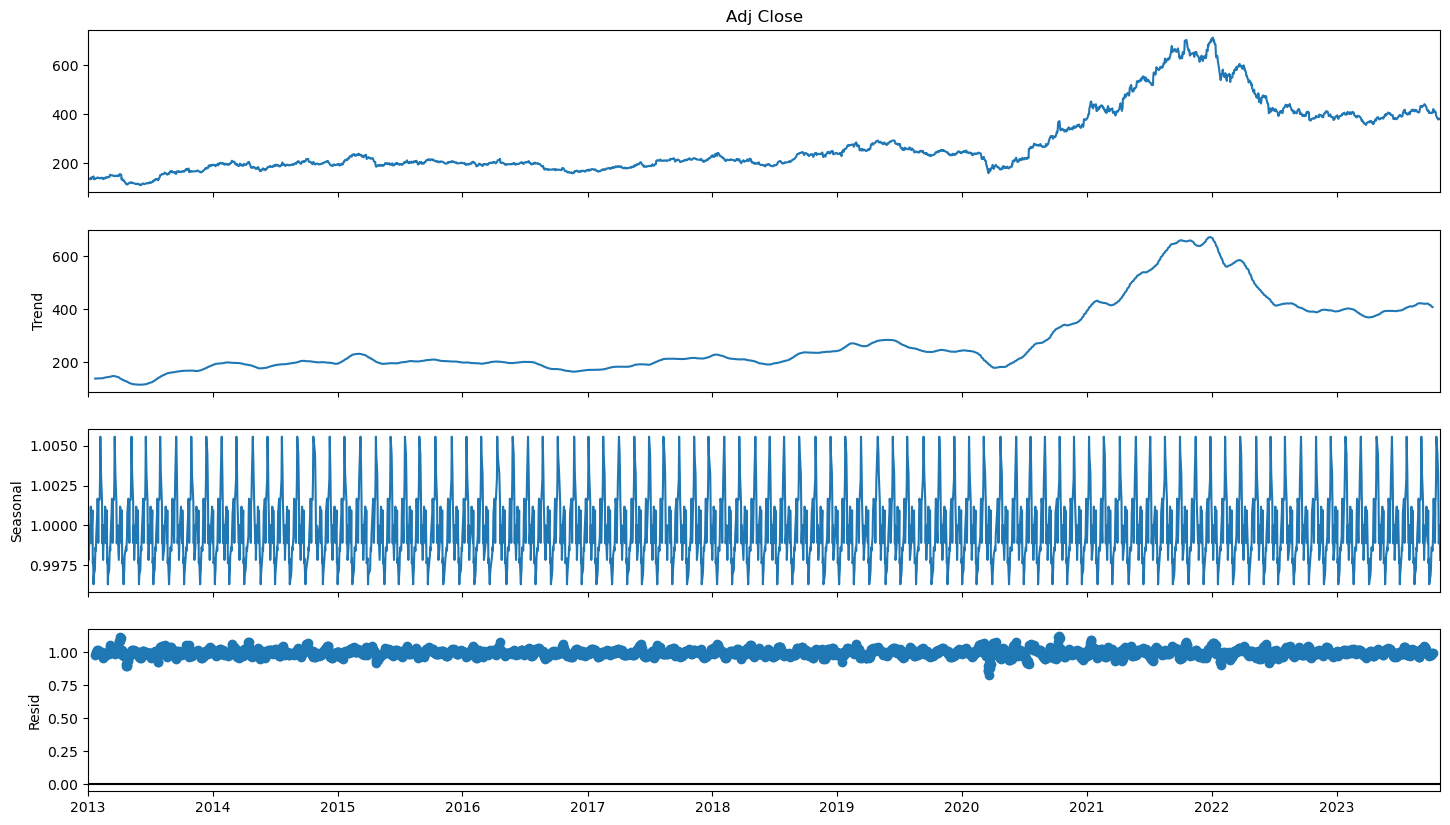

In [6]:

df_close = df['Adj Close']

result = seasonal_decompose(df_close, model='multiplicative',period =30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

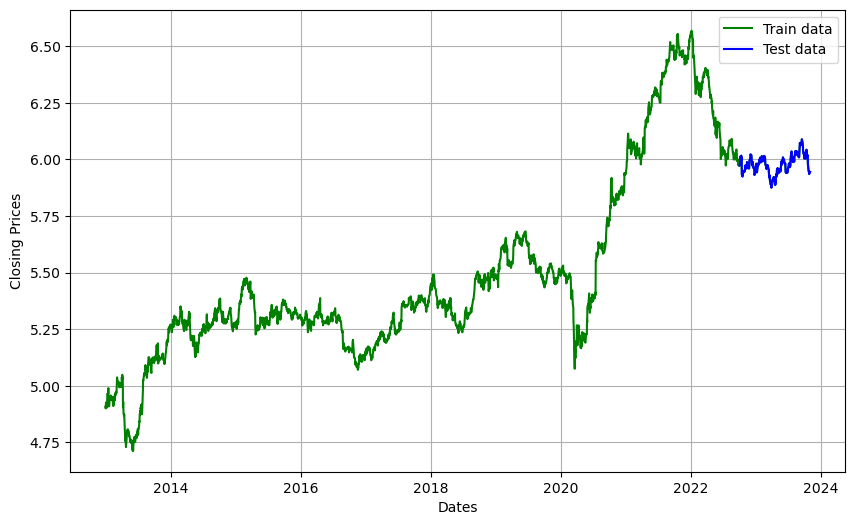

In [7]:
## Eliminate Trend
df_close = df['Adj Close']
df_log = np.log(df_close)
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## Optimal order selection

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12865.874, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12864.092, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12864.094, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12866.178, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12862.093, Time=1.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.929 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2405
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6434.089
Date:                Wed, 15 Nov 2023   AIC                         -12866.178
Time:                        12:19:37   BIC                         -12860.394
Sample:                             0   HQIC                        -12864.074
                               - 2405                             

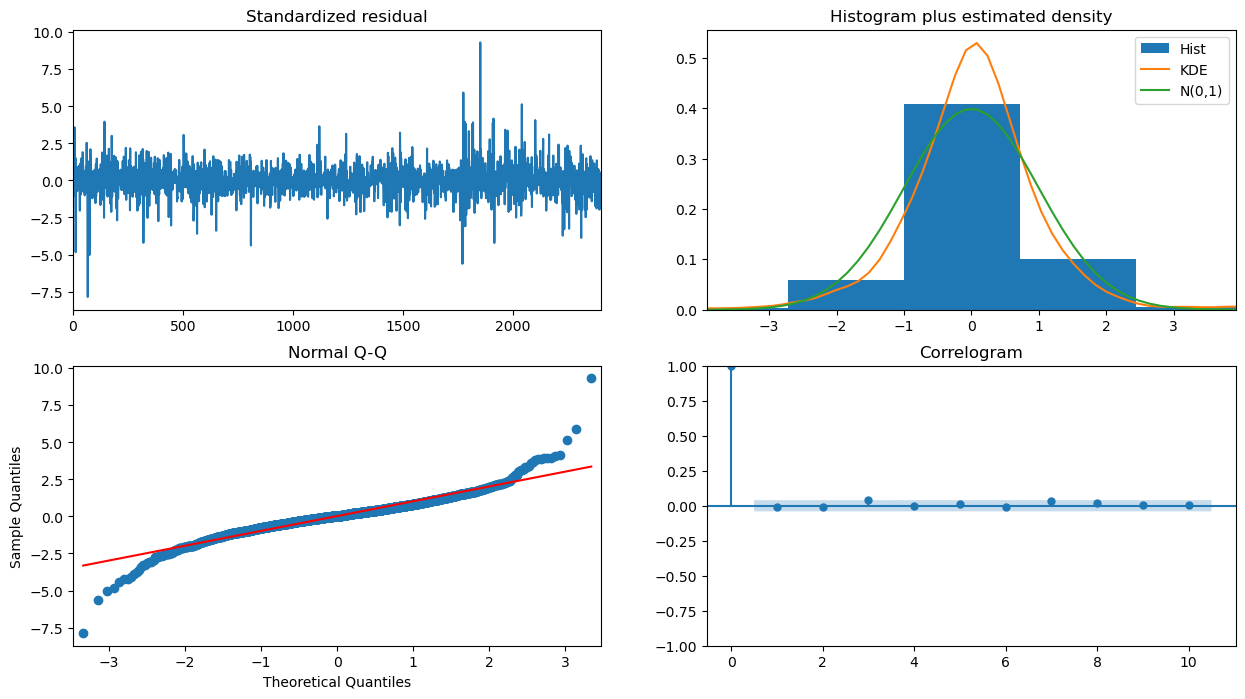

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

## Modeling & Forecasting

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


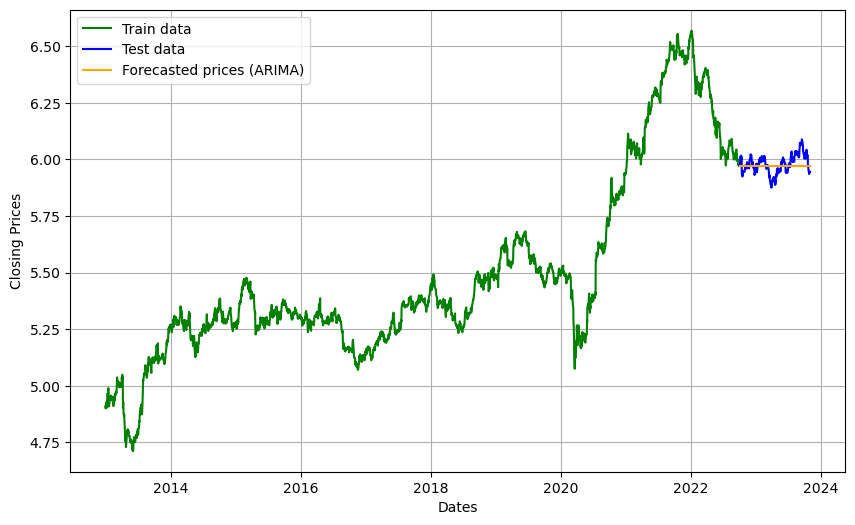

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA Modeling
# Build Model
model_sarima = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))  
fitted_sarima = model_sarima.fit(disp=-1)  

# Forecasting
fc_sarima = fitted_sarima.get_forecast(steps=len(test_data))
fc_series_sarima = pd.Series(fc_sarima.predicted_mean.values, index=test_data.index)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.plot(fc_series_sarima, 'orange', label='Forecasted prices (ARIMA)')
plt.legend()
plt.show()


## Accuracy Metrics

In [24]:
# Report performance for SARIMA
mse_sarima = mean_squared_error(test_data, fc_series_sarima)
print('MSE (ARIMA): ' + str(mse_sarima))

mae_sarima = mean_absolute_error(test_data, fc_series_sarima)
print('MAE (ARIMA): ' + str(mae_sarima))

rmse_sarima = math.sqrt(mean_squared_error(test_data, fc_series_sarima))
print('RMSE (ARIMA): ' + str(rmse_sarima))

mape_sarima = np.mean(np.abs(fc_series_sarima - test_data) / np.abs(test_data))
print('MAPE (ARIMA): ' + str(mape_sarima))


MSE (ARIMA): 0.0017654913404885543
MAE (ARIMA): 0.03343096196949649
RMSE (ARIMA): 0.04201775030256325
MAPE (ARIMA): 0.00558230113973131


**With MAPE of around 0.5 % the model is 99.5 % accurate in predicting the next 268 observations.**